In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import glm
import collections
from statsmodels.sandbox.stats.multicomp import multipletests
import time
from folium import plugins
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import os
from calendar import month_name
import datetime

In [2]:
df=pd.read_csv('Final_poisson.csv').iloc[:,1:]

In [3]:
def conteo_perf(newdf=df):
    df_drop=newdf.drop_duplicates(subset='LAT_LON') 
    conteos=newdf[['LAT_LON','SITIO_EXACTO_ACCIDENTE']].groupby(['LAT_LON','SITIO_EXACTO_ACCIDENTE']).size().reset_index(name='count')
    grp_conteos = conteos.groupby('LAT_LON')['count'].agg(['sum','max'])
    grp_conteos['sum_rate'] = grp_conteos['max'] / grp_conteos['sum']
    filtered_conteos = grp_conteos[grp_conteos['sum_rate'] > 0.3]
    return_df = filtered_conteos.drop(['max', 'sum_rate'], axis=1)
    return_df.rename(columns = {'sum':'NACCIDENTS'}, inplace = True) 
    fusion=pd.merge(return_df,df_drop,on='LAT_LON',how='inner')[['NACCIDENTS','AÑO_ACCIDENTE','MES_ACCIDENTE',
                                                     'CLASE_ACCIDENTE','LONGITUD', 'LATITUD',
                                                     'POT', 'PIEZA_URBANA', 'BUS_SUBIDA','BUS_BAJADA', 
                                                     'TRAFICO','ES_FESTIVO','SOLO_HORA','DIA_ACCIDENTE','JUNIOR_JUGO']].reset_index().iloc[:,1:]
    return(fusion)

In [4]:
semaforos=pd.read_csv('lights_clean.csv')[['LATITUD','LONGITUD']]

In [5]:
def distancia_semaforos_mas_rapido(final_df,lights=semaforos):
    closest=np.zeros(final_df.shape[0])
    numclose=np.zeros(final_df.shape[0])
    numclose2=np.zeros(final_df.shape[0])
    numclose3=np.zeros(final_df.shape[0])
    for i in range(final_df.shape[0]):
        corner_lat=final_df['LATITUD'][i]
        corner_lon=final_df['LONGITUD'][i]
        light_lat=np.array(lights['LATITUD'])
        light_lon=np.array(lights['LONGITUD'])
        dx = (light_lon-corner_lon)*40000*np.cos((light_lat+corner_lat)*math.pi/360)/360
        dy = (light_lat-corner_lat)*40000/360
        distance=np.sqrt(dx**2+dy**2)
        closest[i]=distance[distance.argmin()]
        numclose[i]=np.sum(distance<0.1)
        numclose2[i]=np.sum(((distance>=0.1) & (distance<0.5)))
        numclose3[i]=np.sum(((distance>=0.5) & (distance<2)))
    final_df['NLIGHTS']=list(numclose)
    final_df['NLIGHTS2']=list(numclose2)
    final_df['NLIGHTS3']=list(numclose3)
    final_df['CLOSEST_LIGHT']=list(closest)
    return(final_df)

In [6]:
def modelo_poisson(dia=False,mes=False,hora=25, df=df,lights=semaforos,lights_aux=semaforos): #Ojo dia, festivo, mes, año tienen que ser excluyente, si uno es verdadero automaticamente los otros son falsos
        if(mes!=False):
            aux=df[df.MES_ACCIDENTE!=mes].copy()
            df=df[df.MES_ACCIDENTE==mes]
            conteo_cero=conteo_perf(newdf=aux)
            conteo_cero['NACCIDENTS']=0
            data=conteo_perf(newdf=df)
            data=pd.concat([data,conteo_cero]).reset_index(drop=True)
        if(dia!=False):
            aux=df[df.DIA_ACCIDENTE!=dia].copy()
            df=df[df.DIA_ACCIDENTE==dia]
            conteo_cero=conteo_perf(newdf=aux)
            conteo_cero['NACCIDENTS']=0
            data=conteo_perf(newdf=df)
            data=pd.concat([data,conteo_cero]).reset_index(drop=True)
        if(hora!=25):
            df=df[df.SOLO_HORA==hora]
            aux=df[df.SOLO_HORA!=hora]
            conteo_cero=conteo_perf(newdf=aux)
            conteo_cero['NACCIDENTS']=0
            data=conteo_perf(newdf=df)
            data=pd.concat([data,conteo_cero]).reset_index(drop=True)
        if((mes==False)&(dia==False)&(hora==25)):
            data=conteo_perf(newdf=df)            
        data_aux=data.copy()
        data=distancia_semaforos_mas_rapido(final_df=data,lights=lights)
        data_aux=distancia_semaforos_mas_rapido(final_df=data_aux,lights=lights_aux)
        formula='NACCIDENTS~BUS_SUBIDA+BUS_BAJADA+POT+PIEZA_URBANA+NLIGHTS+NLIGHTS2+TRAFICO+CLOSEST_LIGHT'
        model = glm(formula=formula, data=data, family=sm.families.Poisson()).fit()
        data_aux['PREDICHOS']=model.predict(data_aux)   
        data['PREDICHOS']=model.predict()
        return([data[['LATITUD','LONGITUD','PREDICHOS']],data_aux[['LATITUD','LONGITUD','PREDICHOS']]])

In [26]:
def mapa_calor_año(lights_aux=semaforos):
    id=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    modelo=modelo_poisson(lights_aux=lights_aux)
    mapa_barranquilla_observados = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
    mapa_barranquilla_predichos = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
    capa_calor_observados=HeatMap(modelo[0][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
    capa_calor_predichos=HeatMap(modelo[1][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
    mapa_barranquilla_predichos.add_child(capa_calor_predichos)
    mapa_barranquilla_observados.add_child(capa_calor_observados)
    mapa_barranquilla_observados.save('anho_asIs_'+id+'.html')
    mapa_barranquilla_predichos.save('anho_toBe_'+id+'.html')
    anho={}
    anho['conteo_toBe']=round(np.sum(modelo[1]['PREDICHOS']),0)
    anho['conteo_asIs']=round(np.sum(modelo[0]['PREDICHOS']),0)
    anho['id']=id
    anho['key']='Year'
    anho['AsIs']='anho_asIs_'+id+'.html'
    anho['toBe']='anho_toBe_'+id+'.html'
    lista=[anho]
    return(lista)

def video_mapa_hora(horas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],lights_aux=semaforos):
#     aux_predichos=[]
#     aux_observados=[]
    lista=[]
    id=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    for i in horas:
        
        modelo=modelo_poisson(hora=i,lights_aux=lights_aux)
        mapa_barranquilla_observados = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
        mapa_barranquilla_predichos = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
        capa_calor_observados=HeatMap(modelo[0][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
        capa_calor_predichos=HeatMap(modelo[1][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
        mapa_barranquilla_predichos.add_child(capa_calor_predichos)
        mapa_barranquilla_observados.add_child(capa_calor_observados)
        mapa_barranquilla_observados.save('hora_'+str(i)+'_asIs_'+id+'.html')
        mapa_barranquilla_predichos.save('hora_'+str(i)+'_toBe_'+id+'.html')
        aux={}
        aux['conteo_toBe']=round(np.sum(modelo[1]['PREDICHOS']),0)
        aux['conteo_asIs']=round(np.sum(modelo[0]['PREDICHOS']),0)
        aux['id']=id
        aux['key']=str(i)
        aux['asIs']='hora_'+str(i)+'_asIs_'+id+'.html'
        aux['toBe']='hora_'+str(i)+'_toBe_'+id+'.html'
        lista.append(aux)
#         aux_predichos.append(mapa_barranquilla_predichos)
#         aux_observados.append(mapa_barranquilla_observados)
    return(lista)

def video_mapa_mes(mes=[1,2,3,4,5,6,7,8,9,10,11,12],lights_aux=semaforos):
#     aux_predichos=[]
    lista=[]
    id=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
#     aux_observados=[]
    for i in mes:
        modelo=modelo_poisson(mes=i,lights_aux=lights_aux)
        mapa_barranquilla_observados = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
        mapa_barranquilla_predichos = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
        capa_calor_observados=HeatMap(modelo[0][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
        capa_calor_predichos=HeatMap(modelo[1][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
        mapa_barranquilla_predichos.add_child(capa_calor_predichos)
        mapa_barranquilla_observados.add_child(capa_calor_observados)
        mapa_barranquilla_observados.save('mes_'+month_name[i]+'_asIs_'+id+'.html')
        mapa_barranquilla_predichos.save('mes_'+month_name[i]+'_toBe_'+id+'.html')
#         aux_predichos.append(mapa_barranquilla_predichos)
#         aux_observados.append(mapa_barranquilla_observados)
        aux={}
        aux['conteo_toBe']=round(np.sum(modelo[1]['PREDICHOS']),0)
        aux['conteo_asIs']=round(np.sum(modelo[0]['PREDICHOS']),0)
        aux['key']=month_name[i]
        aux['id']=id
        aux['asIs']='mes_'+month_name[i]+'_asIs_'+id+'.html'
        aux['toBe']='mes_'+month_name[i]+'_toBe_'+id+'.html'
        lista.append(aux)
    return(lista)


def video_mapa_dia(dias=['Lun','Mar','Mié','Jue','Vie','Sáb','Dom'],lights_aux=semaforos):
#     aux_predichos=[]
    lista=[]
    id=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
#     aux_observados=[]
    for i in dias:
        modelo=modelo_poisson(dia=i,lights_aux=lights_aux)
        mapa_barranquilla_observados = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
        mapa_barranquilla_predichos = folium.Map(location=[10.980706, -74.807636],zoom_start=13,tiles="OpenStreetMap")
        capa_calor_observados=HeatMap(modelo[0][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
        capa_calor_predichos=HeatMap(modelo[1][['LATITUD','LONGITUD','PREDICHOS']],radius=15)
        mapa_barranquilla_predichos.add_child(capa_calor_predichos)
        mapa_barranquilla_observados.add_child(capa_calor_observados)
        mapa_barranquilla_observados.save('dia_'+i+'_asIs_'+id+'.html')
        mapa_barranquilla_predichos.save('dia_'+i+'_toBe_'+id+'.html')
        aux={}
        aux['conteo_toBe']=round(np.sum(modelo[1]['PREDICHOS']),0)
        aux['conteo_asIs']=round(np.sum(modelo[0]['PREDICHOS']),0)
        aux['id']=id
        aux['key']=i
        aux['asIs']='dia_'+i+'_asIs_'+id+'.html'
        aux['toBe']='dia_'+i+'_toBe_'+id+'.html'
        lista.append(aux)        
#         aux_predichos.append(mapa_barranquilla_predichos)
#         aux_observados.append(mapa_barranquilla_observados)
    return(lista)

In [7]:
def funcion_final(dia=False,mes=False,hora=25, df=df,lights=semaforos,lights_aux=semaforos):
    
    if(mes!=False):
        return(video_mapa_mes(mes=mes,lights_aux=semaforos))            
    if(dia!=False):
        return(video_mapa_dia(dias=dia,lights_aux=semaforos))
    if(hora!=25):
        return(video_mapa_hora(horas=hora,lights_aux=semaforos))
    return(mapa_calor_año(lights_aux=semaforos))

In [10]:
conteo=conteo_perf()
sema=semaforos.copy()

In [17]:
distancia

,NACCIDENTS,AÑO_ACCIDENTE,MES_ACCIDENTE,CLASE_ACCIDENTE,LONGITUD,LATITUD,POT,PIEZA_URBANA,BUS_SUBIDA,BUS_BAJADA,TRAFICO,ES_FESTIVO,SOLO_HORA,DIA_ACCIDENTE,JUNIOR_JUGO,NLIGHTS,NLIGHTS2,NLIGHTS3,CLOSEST_LIGHT
0,1,2019,4,Choque,-74.810748,10.915367,protegida,ninguna,0,0,0.003922,YES,11,Sáb,1,0.0,0.0,0.0,2.074364
1,1,2018,5,Choque,-74.795213,10.917122,protegida,ninguna,3,0,0.003922,NO,14,Vie,1,0.0,0.0,3.0,1.507733
2,1,2018,1,Choque,-74.807522,10.917998,protegida,ninguna,2,0,0.705882,NO,11,Mié,1,0.0,0.0,3.0,1.630849
3,1,2019,6,Choque,-74.797185,10.918646,protegida,ninguna,2,0,0.003922,NO,15,Jue,1,0.0,0.0,3.0,1.294282
4,1,2019,5,Choque,-74.826326,10.921112,protegida,ninguna,0,0,0.294118,NO,13,Jue,1,0.0,0.0,0.0,2.777795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5825,1,2016,9,Choque,-74.827026,11.040540,residencial,ribera occidental,1,0,0.705882,NO,11,Vie,1,0.0,0.0,0.0,2.691293
5826,1,2018,4,Atropello,-74.824731,11.040967,residencial,ribera occidental,1,0,0.003922,NO,20,Lun,1,0.0,0.0,0.0,2.772020
5827,1,2017,5,Atropello,-74.827933,11.041935,residencial,ribera occidental,1,0,0.705882,NO,15,Lun,1,0.0,0.0,0.0,2.811648
5828,1,2018,1,Choque,-74.826731,11.042032,residencial,ribera occidental,1,0,0.701961,NO,9,Mié,1,0.0,0.0,0.0,2.858991


In [75]:
current_data=distancia_semaforos_mas_rapido(final_df=conteo)
formula='NACCIDENTS~BUS_SUBIDA+BUS_BAJADA+POT+PIEZA_URBANA+NLIGHTS+NLIGHTS2+TRAFICO+CLOSEST_LIGHT'
model = glm(formula=formula, data=current_data, family=sm.families.Poisson()).fit()
sumas_predichos=np.round(np.sum(model.predict()),0)
esquina=distancia[distancia['CLOSEST_LIGHT']>=0.05][['LATITUD','LONGITUD']]
esquina['PROB']=1/sumas_predichos
sema_aux=sema.copy()

In [ ]:
for i in range(1000): 
    current_data=distancia_semaforos_mas_rapido(final_df=conteo,lights=sema_aux)
    sumas_predichos=np.round(np.sum(model.predict(current_data)),0)
    muestra=esquina.sample(weights=esquina['PROB'],n=100)
    esquina['PROB'].loc[muestra.index]=(esquina['PROB'].loc[muestra.index]+1/sumas_predichos)/2
    sema_aux=pd.concat([sema,muestra[['LATITUD','LONGITUD']]]).reset_index(drop=True)
    print(sumas_predichos)

18720.0
18714.0
18679.0
18697.0
18680.0
18730.0
18697.0
18691.0
18701.0
18653.0
18688.0
18729.0
18721.0
18717.0
18686.0
18694.0
18683.0
18679.0
18722.0
18662.0
18630.0
18670.0
18715.0
18699.0
18654.0
18685.0
18668.0
18635.0
18718.0
18684.0
18655.0
18666.0
18693.0
18631.0
18737.0
18664.0
18629.0
18641.0
18686.0
18681.0
18705.0
18724.0
18665.0
18660.0
18688.0
18694.0
18727.0
18699.0
18705.0
18659.0
18695.0
18711.0
18718.0
18651.0
18625.0
18709.0
18662.0
18668.0
18703.0
18635.0
18662.0
18670.0
18682.0
18674.0
18668.0
18613.0
18709.0
18670.0
18667.0
18675.0
18694.0
18676.0
18714.0
18674.0
18729.0
18666.0
18702.0
18675.0
18709.0
18622.0
18727.0
18703.0
18671.0
18699.0
18713.0
18649.0
18653.0
18671.0
18647.0
18632.0
18707.0
18711.0
18702.0
18755.0
18629.0
18692.0
18714.0
18654.0
18681.0
18677.0
18691.0
18633.0
18689.0
18691.0
18658.0
18693.0
18668.0
18656.0
18655.0
18683.0
18717.0
18724.0
18632.0
18701.0
18690.0
18684.0
18659.0
18618.0
18657.0
18690.0
18707.0
18716.0
18724.0
18721.0
18662.0


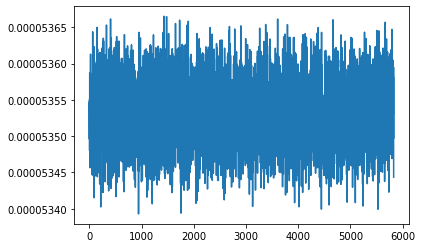

In [87]:
plt.plot(esquina['PROB'])

In [58]:
a['PROB'].loc[muestra.index]

5547    0.000053
5433    0.000053
885     0.000053
4232    0.000053
579     0.000053
3354    0.000053
2116    0.000053
1937    0.000053
2745    0.000053
1246    0.000053
1711    0.000053
5450    0.000053
1460    0.000053
5059    0.000053
5679    0.000053
5108    0.000053
3686    0.000053
2262    0.000053
4530    0.000053
1637    0.000053
2196    0.000053
3851    0.000053
2178    0.000053
1156    0.000053
3606    0.000053
1017    0.000053
2538    0.000053
314     0.000053
3777    0.000053
3382    0.000053
3349    0.000053
128     0.000053
4215    0.000053
1100    0.000053
1527    0.000053
2988    0.000053
4568    0.000053
1212    0.000053
4333    0.000053
2021    0.000053
1886    0.000053
1494    0.000053
4499    0.000053
2302    0.000053
419     0.000053
5223    0.000053
1479    0.000053
3078    0.000053
1028    0.000053
907     0.000053
Name: PROB, dtype: float64